In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image


from dataProcessing import train_loader, val_loader
from models import LeNet5

<class 'torch.utils.data.dataset.Subset'>


In [3]:
batch = next(iter(train_loader)) # loads one batch of training data

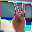

10


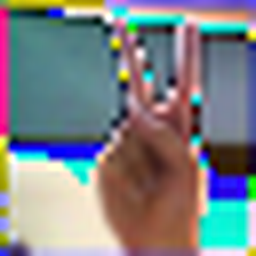

In [4]:
# displays the image and the label to make sure everything is working well

pil_image = transforms.ToPILImage()(batch[0][0])
display(pil_image)
print(batch[1][0].item()) # label of the image

resized_image = pil_image.resize((256, 256), Image.LANCZOS)
display(resized_image)

In [5]:
model = LeNet5()

In [7]:
def train(model, train_loader, optimizer, loss_criteria, epoch):
    """ Trains the model parameters and returns loss at each 
    epoch
    
    Args:
    model - pytorch model to train
    train_loader - pytorch dataLoader class 
    optimizer - pytorch optimizer object
    epoch - what the current epoch is
    """
    
    # sets the model to training mode
    model.train()
    loss_tracker = 0
    
    # progress bar
    train_loader_iter = tqdm(train_loader, desc = f"Epoch {epoch + 1}")
    
    
    for data,label in train_loader_iter:

        # resets the gradients
        optimizer.zero_grad()
        
        # model's current prediction
        prediction = model(data)
        
        # tracks loss
        loss = loss_criteria(prediction, label)
        loss_tracker += loss.item()
        
        # calculates gradient
        loss.backward()
        optimizer.step()
        
    return loss_tracker
        

In [10]:
learning_rate = 0.01
epochs = 3
losses = []

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss()

In [11]:
for epoch in range(epochs):
    losses.append(train(model, train_loader, optimizer, loss_criteria, epoch))

Epoch 1:   0%|          | 0/1088 [00:00<?, ?it/s]


RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

In [ ]:
def test(model,test_loader):
    """ Tests the model's accuracy """
    
    #sets model to eval mode
    model.eval()
    correct = 0
    
    with torch.no_grad():
        
        for data, label in test_loader:

            # model's prediction
            output = model(data)
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(label==predicted).item()
            
            
        print(f"Accuracy: {100. * correct / len(test_loader.dataset):.2f}%")

In [ ]:
test(model, val_loader)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!